In [1]:
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import pearsonr,spearmanr

In [2]:
price=pd.read_csv('./data/electricity price/price.csv') # daily

weather=pd.read_csv('./data/weather data/weather.csv') # daily

carbon=pd.read_csv('./data/carbon/Carbon.csv') # daily with missing values
crude=pd.read_csv('./data/Crude/Crude.csv') # daily with missing values
gas=pd.read_csv('./data/Natural gas/gas.csv') # daily with missing values

gdp0=pd.read_csv('./data/gdp per capita/GDP0.csv') # quarterly
gdpi=pd.read_csv('./data/gdp per capita/GDP1.csv') # quarterly
gdp_y=pd.read_csv('./data/gdp per capita/GDP_Y.csv') # yearly
source=pd.read_csv('./data/source/sourceshare.csv') # yearly
netimport=pd.read_csv('./data/net import/netimport.csv') # yearly
ev=pd.read_csv('./data/EV/EVCarsaleshare.csv') # yearly


In [3]:
price=price[['Date','SE1']]
price=price[price['Date']<='2022-04-30'].rename(columns = {'SE1':'Price'})

weather=weather[weather['Date']<='2022-05-31']

carbon=carbon[carbon['Date']<='2022-05-31'].rename(columns = {'Auction Price €/tCO2':'Carbon Price'})

crude=crude.rename(columns = {'Close':'Crude Price'})

gas=gas.rename(columns = {'Close':'Gas Price'})


# 1.Data interpolation for yearly/quarterly data
Many time series analyses assume observations over uniform time intervals.
Many time series analyses assume observations over uniform time intervals. In the real world, incoming data often does not arrive in this way. As a result, one common prerequisite for Time Series analysis is to take an initially raw input and transform it into discrete intervals, or to resample an input at one frequency into an input of a different frequency.

In [4]:
def trans2daily(Data: pd.DataFrame, title: str,shift:int,order: int,comp: bool)-> pd.DataFrame:
    start='2019-01-01'
    end='2022-04-30'
    date=pd.DataFrame()
    date['Date']=pd.date_range(start, end, freq='1d')
    data=Data.copy()
    data['Date']=pd.to_datetime(data['Date'].astype('str'))+datetime.timedelta(days=shift)
    data=pd.merge(date,data,how='outer')
    
    data.index=pd.to_datetime(data['Date'].astype('str'))
    del data['Date']

    data1 = data.resample('1D')

    data['time'] = data1.interpolate(method='time')
    data['spline'] = data1.interpolate(method='spline',order=order)
    data['cubicspline'] = data1.interpolate(method='cubicspline')
    if comp==True:
        data['pad'] = data1.interpolate(method='pad')
        data['poly'] = data1.interpolate(method='polynomial', order=order)

        data['quadratic'] = data1.interpolate(method='quadratic')
        data['cubic'] = data1.interpolate(method='cubic')
        data['akima'] = data1.interpolate(method='akima')
    
    data=data[data.index<='2022-04-30']
    data=data[data.index>='2019-01-01']

    sns.set_style('whitegrid') 
    fig=plt.figure(figsize=(12,6))
    sns.lineplot(data= data,palette='tab10',linewidth=1.5)
    plt.ylabel(title)
    sns.set_context('paper', font_scale=1.5, rc={'lines.linewidth':1.5})
    sns.despine(offset=(10,10),trim=False)
    plt.tight_layout()
    coor1={t:pearsonr(price.Price, data[t])[0] for t in data.iloc[:,1:]}
    coor2={t:spearmanr(price.Price, data[t])[0] for t in data.iloc[:,1:]}
    coor=pd.DataFrame([coor1,coor2]).T
    coor.columns=['pearsonr','spearmanr']
    return data,coor

### 1.0 Source

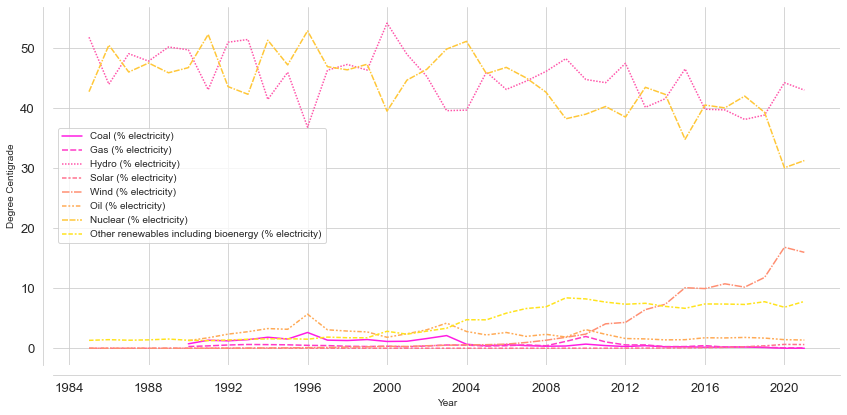

In [5]:
source.index=pd.to_datetime(source['Year'].astype('str'))
del source['Year']
sns.set_style('whitegrid') 
fig=plt.figure(figsize=(12,6))
sns.lineplot(data=source,palette='spring',linewidth=1.5)
plt.ylabel('Degree Centigrade')
sns.set_context('paper', font_scale=1.5, rc={'lines.linewidth':1.5})
sns.despine(offset=(10,10),trim=False)
plt.tight_layout()

### 1.1 GDP per capita

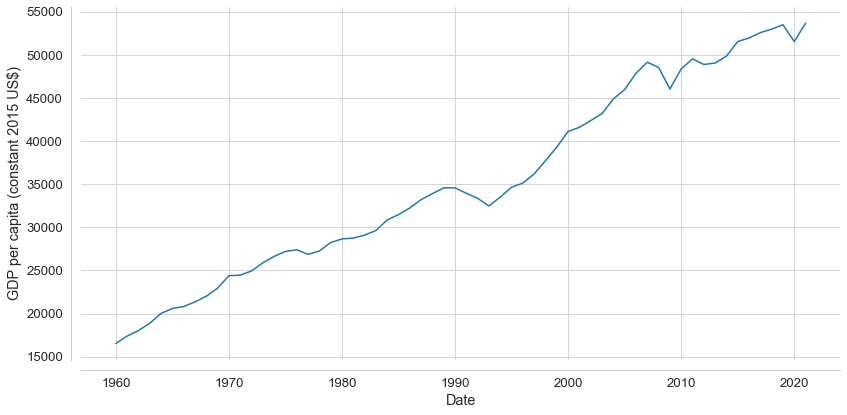

In [6]:
fig=plt.figure(figsize=(12,6))
sns.lineplot(data=gdp_y,x='Date',y='GDP per capita (constant 2015 US$)',linewidth=1.5)
plt.ylabel('GDP per capita (constant 2015 US$)')
sns.set_context('paper', font_scale=1.5, rc={'lines.linewidth':1.5})
sns.despine(offset=(10,10),trim=False)
plt.tight_layout()

In [7]:
gdp1=gdpi.copy()

In [8]:
gdp2=gdpi.append({'Date':'2022-Q2','GDP per capita (constant 2015 US$)':np.mean(gdp1['GDP per capita (constant 2015 US$)'])},ignore_index=True)

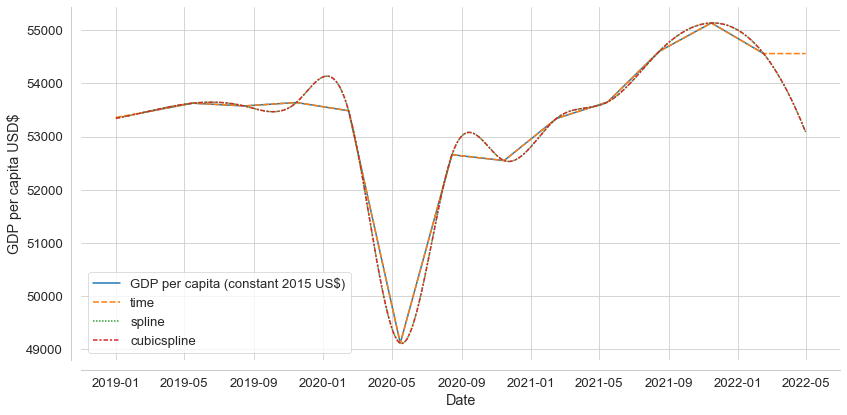

In [9]:
GDP1,Coor1A=trans2daily(gdp1,'GDP per capita USD$',45,3,False)

In [10]:
Coor1A

,pearsonr,spearmanr
time,0.477204,0.461860
spline,0.461848,0.412343
cubicspline,0.461803,0.412071


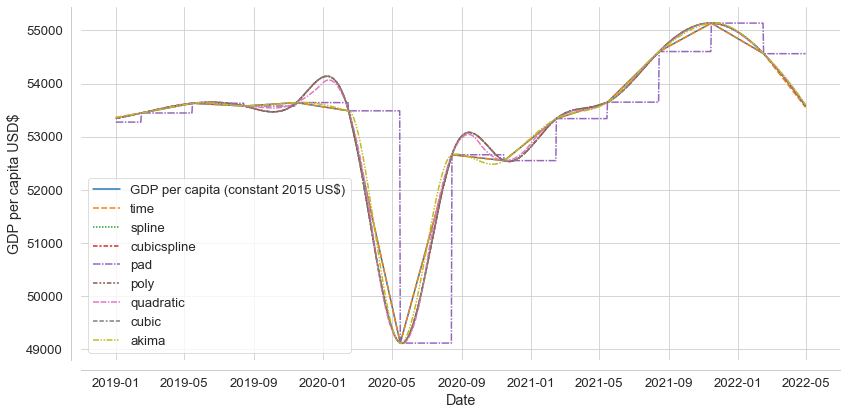

In [11]:
GDP2,Coor1A2=trans2daily(gdp2,'GDP per capita USD$',45,3,True)

In [12]:
Coor1A2

,pearsonr,spearmanr
time,0.474932,0.465373
spline,0.465056,0.420300
cubicspline,0.464991,0.420038
pad,0.366113,0.280860
poly,0.464991,0.420038
quadratic,0.465316,0.428696
cubic,0.464991,0.420038
akima,0.465833,0.449692


In [13]:
gdp_y=gdp_y.append({'Date':'2022','GDP per capita (constant 2015 US$)':np.mean(gdp_y['GDP per capita (constant 2015 US$)'][59:62])},ignore_index=True)

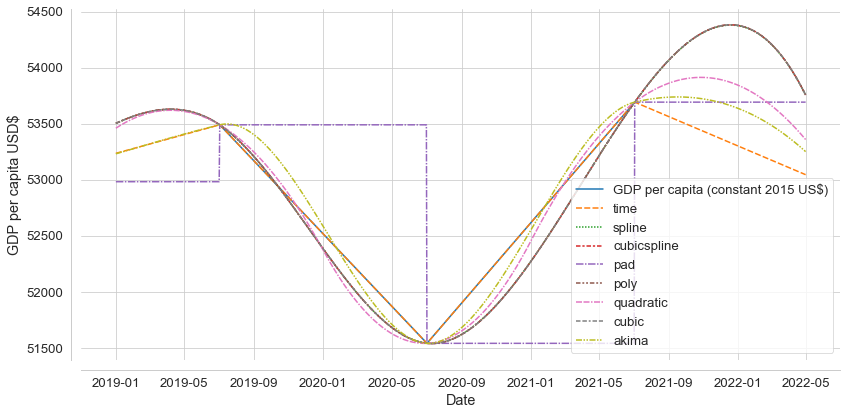

In [14]:
GDP,Coor1B=trans2daily(gdp_y,'GDP per capita USD$',183,3,True)

In [15]:
Coor1B

,pearsonr,spearmanr
time,0.508906,0.565539
spline,0.480090,0.495361
cubicspline,0.480058,0.495183
pad,0.162749,0.143835
poly,0.480058,0.495183
quadratic,0.511489,0.516753
cubic,0.480058,0.495183
akima,0.508110,0.510701


### 1.2 NetImport

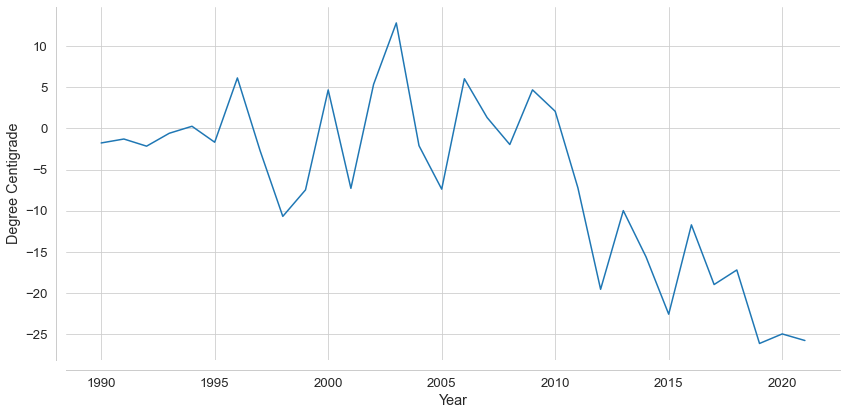

In [16]:
fig=plt.figure(figsize=(12,6))
sns.lineplot(data=netimport,x='Year',y='Net imports (TWh)',linewidth=1.5)
plt.ylabel('Degree Centigrade')
sns.set_context('paper', font_scale=1.5, rc={'lines.linewidth':1.5})
sns.despine(offset=(10,10),trim=False)
plt.tight_layout()

In [17]:
Netimport=netimport.append({'Year':'2022','Net imports (TWh)':np.mean(netimport['Net imports (TWh)'][28:31])},ignore_index=True)

In [18]:
Netimport=Netimport.rename(columns = {'Year':'Date'})

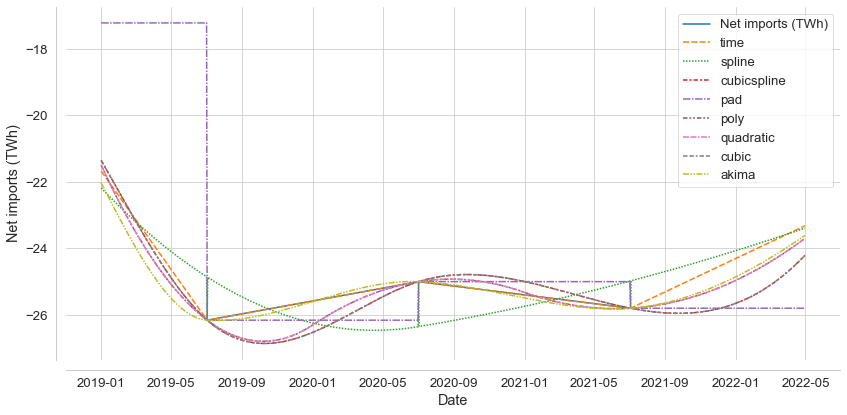

In [19]:
NetImport,Coor2=trans2daily(Netimport,'Net imports (TWh)',183,2,True)

In [20]:
Coor2

,pearsonr,spearmanr
time,0.167865,-0.044170
spline,0.421233,0.519461
cubicspline,0.058160,-0.064787
pad,0.146489,0.194629
poly,0.072967,-0.089474
quadratic,0.072967,-0.089474
cubic,0.058160,-0.064787
akima,0.064771,-0.178084


### 1.3 Electric Vehicle

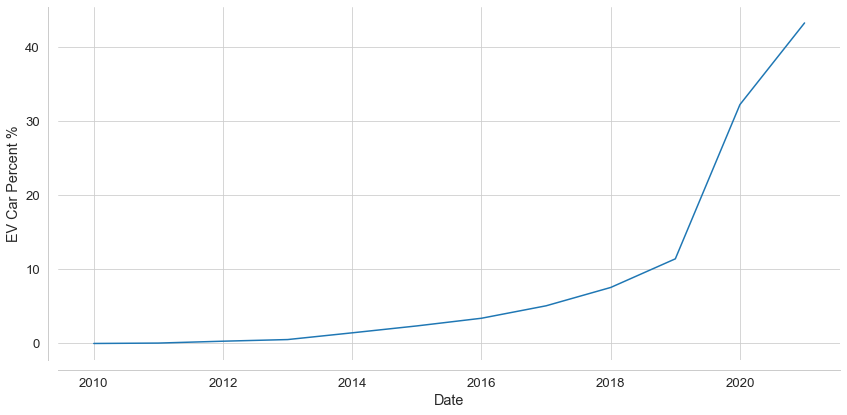

In [21]:
fig=plt.figure(figsize=(12,6))
sns.lineplot(data=ev,x='Date',y='EVCar_Percent',linewidth=1.5)
plt.ylabel('EV Car Percent %')
sns.set_context('paper', font_scale=1.5, rc={'lines.linewidth':1.5})
sns.despine(offset=(10,10),trim=False)
plt.tight_layout()

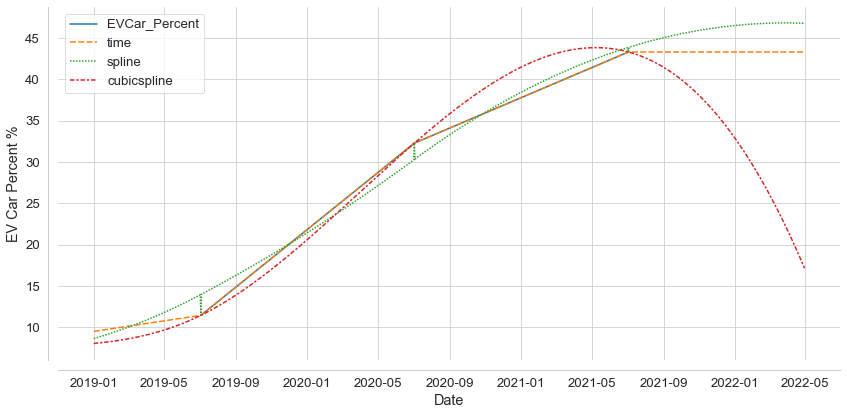

In [22]:
EV,Coor3=trans2daily(ev,'EV Car Percent %',183,2,False)

In [23]:
Coor3

,pearsonr,spearmanr
time,0.014331,0.004849
spline,0.053934,-0.024427
cubicspline,-0.054482,-0.072830


# Imputation methods process the Missing values

Dealing with missing data points (or badly interpolated ones) is not easy. When missing data points are found, there are various approaches that we can consider:

drop all of them (in this case is quite reasonable as they are only a few, percentage-wise).

replace with the mean, median or mode.

replace with a fixed number, like -1 or 0.

Since we are dealing with a time series, none of these methods seems to be appropriate, especially the replacement. Therefore, we could generate this data by creating a predictive model that estimates the missing data from all the other input signals. Then we could fill the gaps by putting these generated values back into the data-set.

第一类是直接删除法，该方法可能会舍弃数据中的一些重要信息；
第二类是基于统计学的填充方法，如均值填充，中值填充，常用值填充，但这类方法忽略了数据的时序信息；
第三类是基于机器学习的填充方法，常见的方法有基于KNN（K-Nearest Neighbor），RNN（Recurrent Neural Networks） ，EM（Expectation-Maximization）和矩阵分解（Matrix Factorization）的缺失值填充算法。然而，这类方法也很少考虑到两个相邻数据间的时序信息。

https://blog.csdn.net/qq_33431368/article/details/117094433

https://blog.csdn.net/anaijiabao/article/details/106632826?spm=1001.2101.3001.6661.1&utm_medium=distribute.pc_relevant_t0.none-task-blog-2%7Edefault%7ECTRLIST%7Edefault-1-106632826-blog-117094433.pc_relevant_default&depth_1-utm_source=distribute.pc_relevant_t0.none-task-blog-2%7Edefault%7ECTRLIST%7Edefault-1-106632826-blog-117094433.pc_relevant_default&utm_relevant_index=1

In [24]:
def missing_process(data: pd.DataFrame,title: str,order: int)->  pd.DataFrame:
    start='2019-01-01'
    end='2022-04-30'
    date=pd.DataFrame()
    date['Date']=pd.date_range(start, end, freq='1d')
    
    data['Date']=pd.to_datetime(data['Date'].astype('str'))

    data=pd.merge(date,data,how='outer')

    data.index=pd.to_datetime(data['Date'].astype('str'))
    del data['Date']

    data1 = data.resample('1D')
    data['time'] = data1.interpolate(method='time')
#     data['pad'] = data1.interpolate(method='pad')
#     data['poly'] = data1.interpolate(method='polynomial', order=order)
    data['spline'] = data1.interpolate(method='spline',order=order)
    data['quadratic'] = data1.interpolate(method='quadratic')
    data['cubic'] = data1.interpolate(method='cubic')
    data['akima'] = data1.interpolate(method='akima')
    data['cubicspline'] = data1.interpolate(method='cubicspline')
#     ‘quadratic’, ‘cubic’‘krogh’, ‘piecewise_polynomial’, ‘spline’, ‘pchip’, ‘akima’, ‘cubicspline’: 

    data=data[data.index>='2019-01-01']
    data=data[data.index<='2022-04-30']

    print(data.isnull().sum())

    sns.set_style('whitegrid') 
    fig=plt.figure(figsize=(12,6))
    sns.lineplot(data= data,palette='tab10',linewidth=1.5)
    plt.ylabel(title)
    sns.set_context('paper', font_scale=1.5, rc={'lines.linewidth':1.5})
    sns.despine(offset=(10,10),trim=False)
    plt.tight_layout()
    coor1={t:pearsonr(price.Price, data[t])[0] for t in data if 'Price' not in t}
    coor2={t:spearmanr(price.Price, data[t])[0] for t in data if 'Price' not in t}
    coor=pd.DataFrame([coor1,coor2]).T
    coor.columns=['pearsonr','spearmanr']
    return data,coor

### 1.Carbon

Carbon Price    740
time              0
spline            0
quadratic         0
cubic             0
akima             0
cubicspline       0
dtype: int64


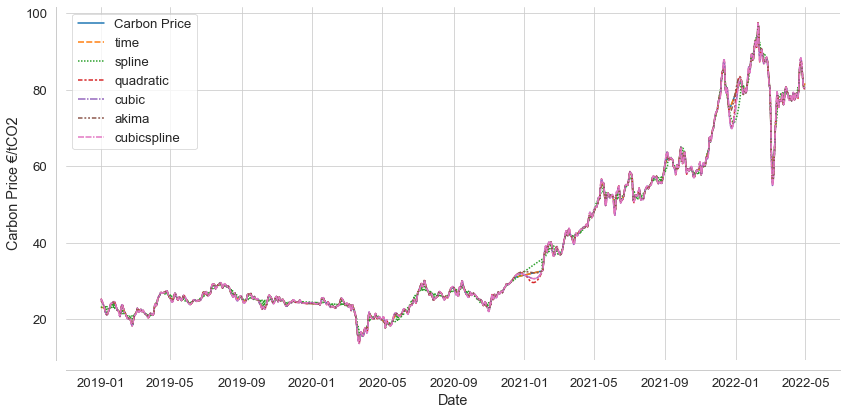

In [25]:
Carbon,coor1=missing_process(carbon,'Carbon Price €/tCO2',2)

In [26]:
carbon

,Date,Carbon Price
0,2018-01-08,7.83
1,2018-01-09,7.68
2,2018-01-11,7.89
3,2018-01-15,7.72
4,2018-01-16,7.77
...,...,...
627,2022-05-19,82.28
628,2022-05-23,78.96
629,2022-05-24,78.88
630,2022-05-30,83.75


In [27]:
Carbon

,Carbon Price,time,spline,quadratic,cubic,akima,cubicspline
Date,,,,,,,
2019-01-01,NaN,23.121429,23.109730,25.389704,25.340460,24.916938,25.340460
2019-01-02,NaN,23.102857,23.147844,25.156210,25.111681,24.727155,25.111681
2019-01-03,NaN,23.084286,23.181569,24.857467,24.822685,24.488984,24.822685
2019-01-04,NaN,23.065714,23.210905,24.493474,24.470745,24.200305,24.470745
2019-01-05,NaN,23.047143,23.235852,24.064232,24.053135,23.858996,24.053135
...,...,...,...,...,...,...,...
2022-04-26,83.43,83.430000,83.430000,83.430000,83.430000,83.430000,83.430000
2022-04-27,NaN,81.990000,82.051687,81.607660,81.584485,81.615707,81.584485
2022-04-28,80.55,80.550000,80.550000,80.550000,80.550000,80.550000,80.550000


In [28]:
coor1

,pearsonr,spearmanr
time,0.285255,0.249269
spline,0.285136,0.246300
quadratic,0.282804,0.248035
cubic,0.283234,0.248435
akima,0.285425,0.250344
cubicspline,0.283234,0.248435


### 2.Brend Crude

Crude Price    379
time             0
spline           0
quadratic        0
cubic            0
akima            0
cubicspline      0
dtype: int64


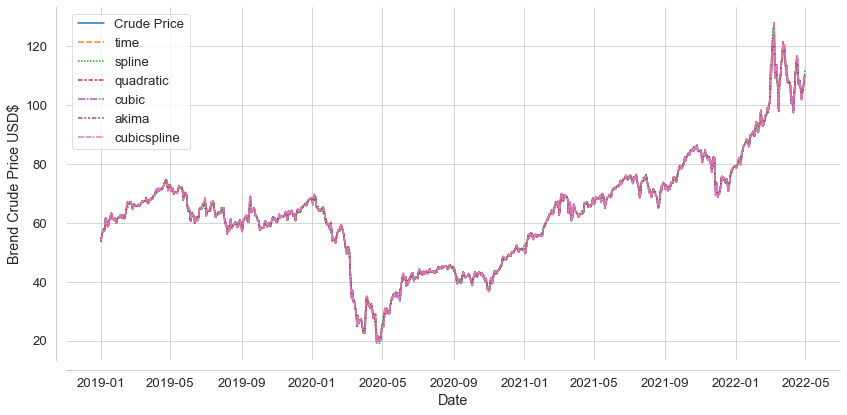

In [29]:
Crude,coor2=missing_process(crude,'Brend Crude Price USD$',5)

In [30]:
Crude

,Crude Price,time,spline,quadratic,cubic,akima,cubicspline
Date,,,,,,,
2019-01-01,NaN,53.594999,53.553026,53.708023,53.837439,53.684175,53.837439
2019-01-02,54.910000,54.910000,54.910000,54.910000,54.910000,54.910000,54.910000
2019-01-03,55.950001,55.950001,55.950001,55.950001,55.950001,55.950001,55.950001
2019-01-04,57.060001,57.060001,57.060001,57.060001,57.060001,57.060001,57.060001
2019-01-05,NaN,57.150002,57.708959,57.389308,57.346631,57.454782,57.346631
...,...,...,...,...,...,...,...
2022-04-26,104.989998,104.989998,104.989998,104.989998,104.989998,104.989998,104.989998
2022-04-27,105.320000,105.320000,105.320000,105.320000,105.320000,105.320000,105.320000
2022-04-28,107.589996,107.589996,107.589996,107.589996,107.589996,107.589996,107.589996


In [31]:
coor2

,pearsonr,spearmanr
time,0.348090,0.428792
spline,0.346904,0.429788
quadratic,0.345134,0.427140
cubic,0.344714,0.426805
akima,0.347722,0.428730
cubicspline,0.344714,0.426805


### 3.Natural gas 

Gas Price      376
time             0
spline           0
quadratic        0
cubic            0
akima            0
cubicspline      0
dtype: int64


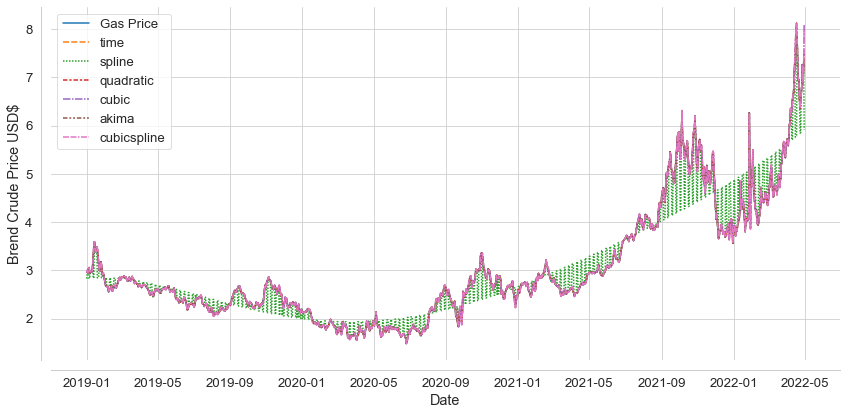

In [32]:
Gas,coor3=missing_process(gas,'Brend Crude Price USD$',5)

In [33]:
Gas

,Gas Price,time,spline,quadratic,cubic,akima,cubicspline
Date,,,,,,,
2019-01-01,NaN,2.949000,2.826552,2.964937,3.009790,2.952653,3.009790
2019-01-02,2.958,2.958000,2.958000,2.958000,2.958000,2.958000,2.958000
2019-01-03,2.945,2.945000,2.945000,2.945000,2.945000,2.945000,2.945000
2019-01-04,3.044,3.044000,3.044000,3.044000,3.044000,3.044000,3.044000
2019-01-05,NaN,3.010667,2.831668,3.060007,3.054899,3.018374,3.054899
...,...,...,...,...,...,...,...
2022-04-26,6.850,6.850000,6.850000,6.850000,6.850000,6.850000,6.850000
2022-04-27,7.267,7.267000,7.267000,7.267000,7.267000,7.267000,7.267000
2022-04-28,6.888,6.888000,6.888000,6.888000,6.888000,6.888000,6.888000


In [34]:
coor3

,pearsonr,spearmanr
time,0.350098,0.443228
spline,0.333950,0.438198
quadratic,0.353731,0.443653
cubic,0.353604,0.443686
akima,0.351310,0.443314
cubicspline,0.353604,0.443686


# Outeliers detection and process

In [35]:
weather.index=pd.to_datetime(weather['Date'].astype('str'))
del weather['Date']

In [36]:
Weather = weather.groupby(pd.Grouper(freq='1M')).mean()

In [37]:
Weather.index=pd.to_datetime(Weather.index.astype('str'))-datetime.timedelta(days=15)
Weather.columns=['monthly_T','monthly_P','monthly_W']

In [38]:
Weather=Weather.reset_index()
weather=weather.reset_index()
Weather=pd.merge(weather,Weather,how='outer')

In [39]:
Weather

,Date,temp,precip,windspeed,monthly_T,monthly_P,monthly_W
0,2018-10-01,8.9,4.03,11.8,NaN,NaN,NaN
1,2018-10-02,7.3,1.98,15.6,NaN,NaN,NaN
2,2018-10-03,7.1,3.88,24.0,NaN,NaN,NaN
3,2018-10-04,5.7,0.02,14.4,NaN,NaN,NaN
4,2018-10-05,12.2,0.06,25.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1334,2022-05-27,11.1,1.88,23.6,NaN,NaN,NaN
1335,2022-05-28,9.8,5.63,14.7,NaN,NaN,NaN
1336,2022-05-29,10.9,0.39,12.2,NaN,NaN,NaN
1337,2022-05-30,11.5,0.00,13.9,NaN,NaN,NaN


In [40]:
def find_outlier(outlier_dataset:pd.DataFrame, option:str):
    Q1 = np.quantile(outlier_dataset,0.25)
    Q3 = np.quantile(outlier_dataset,0.75)
    IQR = Q3-Q1
    Minimum = Q1-1.5*IQR
    Maximum = Q3+1.5*IQR

    # find values that meets the conditions: (outlier_dataset<Minimum) or (outlier_dataset>Maximum)
    outlier_by_IQR_Score=outlier_dataset[(outlier_dataset<Minimum) | (outlier_dataset>Maximum)]
    if outlier_by_IQR_Score.empty ==True:
        print('The '+option+' have not outlier by IQR score')
    else:
        print('The '+option+' classified as outlier by IQR score:\r\n', outlier_by_IQR_Score)
        print('The minimum threshold of'+option+':\r\n,The maximum threshold of'+option+':\r\n', Minimum,Maximum)

The Temperature have not outlier by IQR score


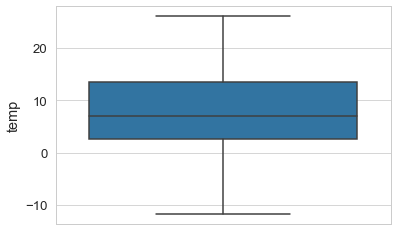

In [41]:
sns.boxplot(y=Weather.temp)
find_outlier(Weather.temp, 'Temperature')

The Precipitation classified as outlier by IQR score:
 0        4.03
2        3.88
29      12.76
39       4.83
40       3.32
        ...  
1318     3.93
1321     3.78
1327     8.47
1335     5.63
1338     8.64
Name: precip, Length: 208, dtype: float64
The minimum threshold ofPrecipitation:
,The maximum threshold ofPrecipitation:
 -1.7924999999999998 2.9875


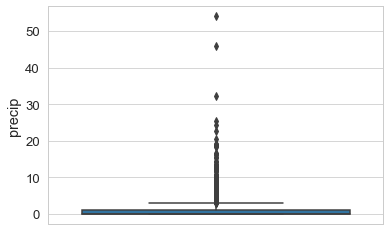

In [42]:
sns.boxplot(y=Weather.precip)
find_outlier(Weather.precip, 'Precipitation')

The windspeed classified as outlier by IQR score:
 93      46.6
349     37.9
496     39.7
497     36.5
509     37.7
549     40.5
550     40.7
563     38.4
892     38.4
1145    39.3
1201    38.6
1204    36.0
1217    42.6
1272    40.2
1274    44.1
Name: windspeed, dtype: float64
The minimum threshold ofwindspeed:
,The maximum threshold ofwindspeed:
 3.549999999999997 35.95


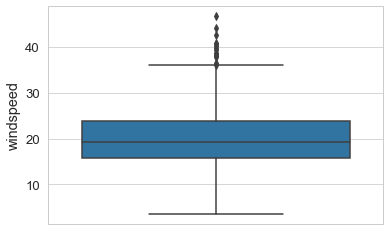

In [43]:
sns.boxplot(y=Weather.windspeed)
find_outlier(Weather.windspeed, 'windspeed')

In [44]:
def wearther_proces(data: pd.DataFrame,option: str,title: str,order: int)->  pd.DataFrame:
    start='2019-01-01'
    end='2022-04-30'
    date=pd.DataFrame()
    date['Date']=pd.date_range(start, end, freq='1d')

    data['Date']=pd.to_datetime(data['Date'].astype('str'))

    data=pd.merge(date,data,how='outer')
    
    data.index=pd.to_datetime(data['Date'].astype('str'))
    if option=='T':
        data=data.loc[:,['Date','monthly_T','temp']]
        data1 = data['monthly_T'].resample('1D')
    if option=='P':
        data=data.loc[:,['Date','monthly_P','precip']]
        data1 = data['monthly_P'].resample('1D')
    if option=='W':
        data=data.loc[:,['Date','monthly_W','windspeed']]
        data1 = data['monthly_W'].resample('1D')
    del data['Date']        
    data['time'] = data1.interpolate(method='time')
    #     data['pad'] = data1.interpolate(method='pad')
    #     data['poly'] = data1.interpolate(method='polynomial', order=order)
    data['spline'] = data1.interpolate(method='spline',order=order)
    data['quadratic'] = data1.interpolate(method='quadratic')
    data['cubic'] = data1.interpolate(method='cubic')
    data['akima'] = data1.interpolate(method='akima')
    data['cubicspline'] = data1.interpolate(method='cubicspline')
    data=data[data.index>='2019-01-01']
    data=data[data.index<='2022-04-30']

    print(data.isnull().sum())

    sns.set_style('whitegrid') 
    fig=plt.figure(figsize=(12,6))
    sns.lineplot(data= data,palette='tab10',linewidth=1.5)
    plt.ylabel(title)
    sns.set_context('paper', font_scale=1.5, rc={'lines.linewidth':1.5})
    sns.despine(offset=(10,10),trim=False)
    plt.tight_layout()

    coor1={t:pearsonr(price.Price, data[t])[0] for t in data.iloc[:,1:]}
    coor2={t:spearmanr(price.Price, data[t])[0] for t in data.iloc[:,1:]}
    coor=pd.DataFrame([coor1,coor2]).T
    coor.columns=['pearsonr','spearmanr']
    return data,coor

monthly_T      1176
temp              0
time              0
spline            0
quadratic         0
cubic             0
akima             0
cubicspline       0
dtype: int64


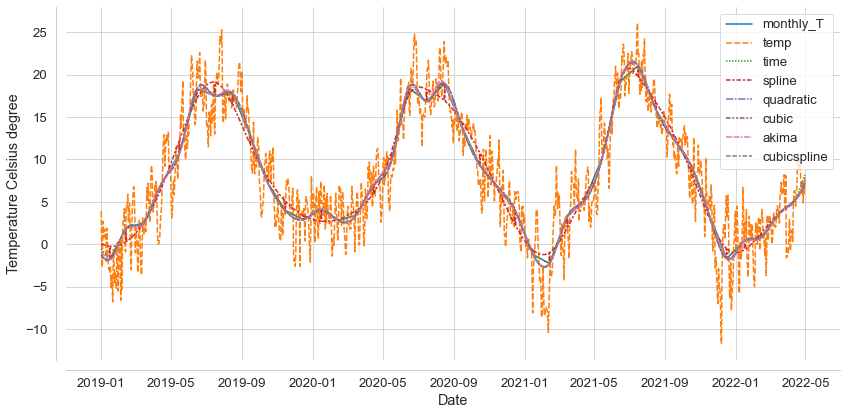

In [45]:
temp,coorT=wearther_proces(Weather,'T','Temperature Celsius degree',3)

In [46]:
temp

,monthly_T,temp,time,spline,quadratic,cubic,akima,cubicspline
Date,,,,,,,,
2019-01-01,NaN,3.9,-0.547659,0.074795,-1.201362,-1.288852,-0.886509,-1.288852
2019-01-02,NaN,-1.1,-0.630073,0.040757,-1.316735,-1.385643,-0.971151,-1.385643
2019-01-03,NaN,-2.7,-0.712487,0.008614,-1.421175,-1.475566,-1.052799,-1.475566
2019-01-04,NaN,2.7,-0.794901,-0.021638,-1.514680,-1.558104,-1.131326,-1.558104
2019-01-05,NaN,0.8,-0.877315,-0.050004,-1.597251,-1.632738,-1.206605,-1.632738
...,...,...,...,...,...,...,...,...
2022-04-26,NaN,7.3,7.424350,6.607556,6.826257,6.501618,6.770258,6.501618
2022-04-27,NaN,4.9,7.614745,6.761698,6.994903,6.647295,6.946238,6.647295
2022-04-28,NaN,7.0,7.805140,6.922693,7.168987,6.800772,7.128658,6.800772


In [47]:
coorT

,pearsonr,spearmanr
temp,-0.175898,-0.129845
time,-0.100257,-0.104522
spline,-0.086249,-0.091290
quadratic,-0.108371,-0.111259
cubic,-0.108850,-0.112255
akima,-0.106540,-0.111562
cubicspline,-0.108850,-0.112255


monthly_P      1176
precip            0
time              0
spline            0
quadratic         0
cubic             0
akima             0
cubicspline       0
dtype: int64


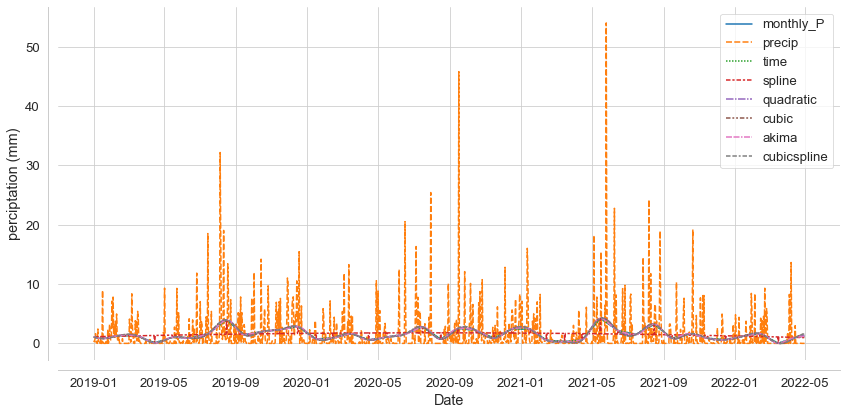

In [48]:
precip,coorp=wearther_proces(Weather,'P','perciptation (mm)',2)

In [49]:
precip

,monthly_P,precip,time,spline,quadratic,cubic,akima,cubicspline
Date,,,,,,,,
2019-01-01,NaN,0.46,1.108824,1.118331,1.075638,1.073630,1.113912,1.073630
2019-01-02,NaN,0.29,1.089053,1.120615,1.043101,1.047945,1.081985,1.047945
2019-01-03,NaN,0.69,1.069282,1.122895,1.012703,1.022762,1.050423,1.022762
2019-01-04,NaN,1.64,1.049511,1.125171,0.984446,0.998238,1.019531,0.998238
2019-01-05,NaN,0.17,1.029740,1.127443,0.958328,0.974528,0.989615,0.974528
...,...,...,...,...,...,...,...,...
2022-04-26,NaN,0.00,1.098613,0.984118,1.274125,1.511386,1.156897,1.511386
2022-04-27,NaN,0.00,1.106456,0.981609,1.288351,1.542369,1.168487,1.542369
2022-04-28,NaN,0.00,1.114300,0.979095,1.300981,1.570027,1.179634,1.570027


In [50]:
coorp

,pearsonr,spearmanr
precip,0.003399,0.022456
time,0.065394,0.116265
spline,-0.272375,-0.457975
quadratic,0.062415,0.108938
cubic,0.059031,0.104338
akima,0.063547,0.117050
cubicspline,0.059031,0.104338


monthly_W      1176
windspeed         0
time              0
spline            0
quadratic         0
cubic             0
akima             0
cubicspline       0
dtype: int64


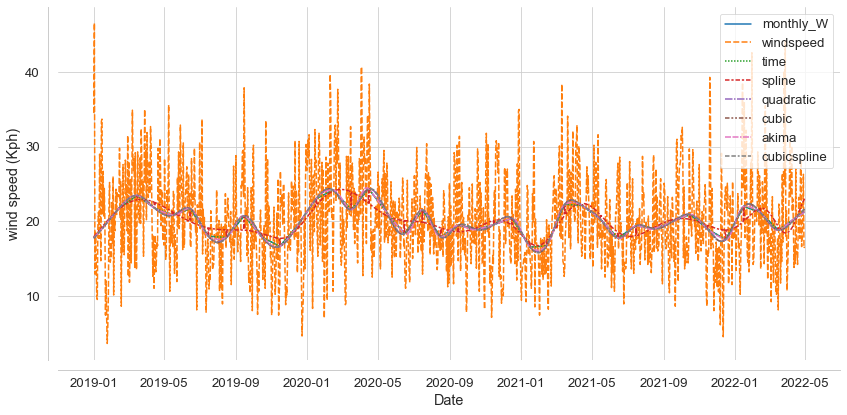

In [51]:
wind,coorw=wearther_proces(Weather,'W','wind speed (Kph)',4)

In [52]:
wind

,monthly_W,windspeed,time,spline,quadratic,cubic,akima,cubicspline
Date,,,,,,,,
2019-01-01,NaN,34.5,17.841415,17.908998,17.711498,17.716219,17.792571,17.716219
2019-01-02,NaN,46.6,17.924246,18.000862,17.800161,17.802005,17.875129,17.802005
2019-01-03,NaN,12.9,18.007076,18.093298,17.889228,17.888769,17.958117,17.888769
2019-01-04,NaN,18.5,18.089906,18.186233,17.978700,17.976465,18.041552,17.976465
2019-01-05,NaN,15.6,18.172737,18.279598,18.068575,18.065043,18.125452,18.065043
...,...,...,...,...,...,...,...,...
2022-04-26,NaN,19.0,20.951370,22.355326,21.092934,21.354969,20.968400,21.354969
2022-04-27,NaN,20.2,20.995737,22.536279,21.142449,21.423244,21.014461,21.423244
2022-04-28,NaN,26.3,21.040104,22.707760,21.190676,21.488335,21.060425,21.488335


In [53]:
coorw

,pearsonr,spearmanr
windspeed,-0.271379,-0.262470
time,-0.302901,-0.312383
spline,-0.288300,-0.330484
quadratic,-0.311507,-0.308906
cubic,-0.313303,-0.308546
akima,-0.301067,-0.308727
cubicspline,-0.313303,-0.308546


<AxesSubplot:>

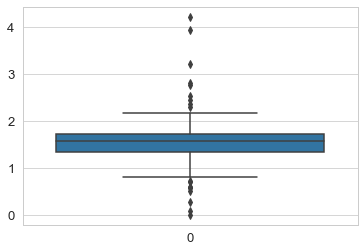

In [54]:
sns.boxplot(data=precip.spline)

<AxesSubplot:>

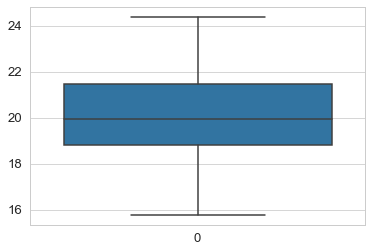

In [55]:
sns.boxplot(data=wind.cubic)

In [56]:
price.index=pd.to_datetime(price['Date'].astype('str'))
del price['Date']

In [57]:
dataset=pd.concat([price.Price,GDP.time,NetImport.spline,EV.spline,Carbon.akima,Crude.spline,Gas.quadratic,temp.temp,precip.spline,wind.cubic],axis=1)

In [58]:
dataset.columns=['Price','GDP','netimport','EV','carbon','crude','gas','temp','precip','wind']

In [59]:
dataset

,Price,GDP,netimport,EV,carbon,crude,gas,temp,precip,wind
Date,,,,,,,,,,
2019-01-01,22.58,53235.984348,-22.185925,8.626756,24.916938,53.553026,2.964937,3.9,1.118331,17.716219
2019-01-02,42.65,53237.374334,-22.204037,8.647441,24.727155,54.910000,2.958000,-1.1,1.120615,17.802005
2019-01-03,51.90,53238.764320,-22.222111,8.668217,24.488984,55.950001,2.945000,-2.7,1.122895,17.888769
2019-01-04,50.85,53240.154306,-22.240147,8.689086,24.200305,57.060001,3.044000,2.7,1.125171,17.976465
2019-01-05,50.72,53241.544292,-22.258144,8.710047,23.858996,57.708959,3.060007,0.8,1.127443,18.065043
...,...,...,...,...,...,...,...,...,...,...
2022-04-26,23.94,53054.303596,-23.413930,46.776081,83.430000,104.989998,6.850000,7.3,0.984118,21.354969
2022-04-27,43.43,53052.154695,-23.407985,46.773722,81.615707,105.320000,7.267000,4.9,0.981609,21.423244
2022-04-28,19.30,53050.005793,-23.402035,46.771280,80.550000,107.589996,6.888000,7.0,0.979095,21.488335


In [60]:
dataset.describe()

,Price,GDP,netimport,EV,carbon,crude,gas,temp,precip,wind
count,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000
mean,31.572574,52885.610116,-25.125105,30.988368,38.777585,63.402135,3.015321,8.078947,1.532006,20.073594
std,21.361478,612.973050,1.074505,12.975762,20.496392,18.490605,1.182590,7.386401,0.280668,1.954251
min,1.130000,51541.655729,-26.464246,8.626756,14.334297,19.057768,1.482000,-11.700000,0.018710,15.779212
25%,15.625000,52392.967691,-26.081828,18.764119,24.277546,51.388898,2.262006,2.800000,1.356842,18.801320
50%,30.995000,53130.589599,-25.324440,33.240645,27.119678,63.950001,2.660000,6.800000,1.593022,19.921641
75%,41.565000,53376.439419,-24.315648,43.764450,53.322466,72.113883,3.614750,14.100000,1.733053,21.479832
max,233.690000,53692.527337,-22.185925,46.808859,97.510000,127.980003,8.131248,26.100000,4.221935,24.381298


In [61]:
dataset.to_csv('./data/preprocessed/data.csv',index=True, header=True)